In [100]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

Численное вычисление градиента.

In [101]:
def gradient(func, x0, step):
    grad = np.zeros(len(x0))

    for i in range(len(x0)):
        x_new = x0.copy()
        x_new[i] += step
        grad[i] = func(*x_new) - func(*x0)
        
    return grad/step

Реализация Backtracking line search

In [102]:
def line_search(func, xk, pk, step, c1=0.1, c2=0.9, MAX_SRCH_ITER=100):
    first_cond = lambda alpha: func(*(xk + alpha*pk)) - func(*xk) - c1*alpha*np.dot(gradient(func, xk, step), pk)
    # second_cond = lambda alpha: abs(np.dot(gradient(func, xk + alpha*pk, step), pk)) - c2*abs(np.dot(gradient(func, xk, step), pk))
    
    num_steps = 0
    alpha = 0.5
    while first_cond(alpha) > 0:
        alpha *= 0.5
        num_steps += 1
        if num_steps == MAX_SRCH_ITER:
            return None
    return alpha

Метод наискорейшего спуска

In [103]:
def grad_desc(func, x0, step=1e-7, eps=1e-7, MAX_DESC_ITER=2000):
    xk = x0
    pk = -gradient(func, xk, step)
    points = np.array([xk])
    
    num_steps = 0
    while num_steps <= MAX_DESC_ITER:
        alpha_opt = line_search(func, xk, pk, step)
        
        if alpha_opt == None:
            break

        xk += alpha_opt*pk
        pk = -gradient(func, xk, step)
        num_steps += 1
        points = np.append(points, [xk], axis=0)

        if np.linalg.norm(alpha_opt*pk) < eps:
            break
    
    return xk, points, num_steps

Метод сопряженных градиентов

In [104]:
class Error(Exception):
    pass

class Wrong_method(Error):
    pass

def CG_grad_desc(func, x0, method, step=1e-7, eps=1e-7, MAX_DESC_ITER=200):
    xk = x0
    gfk = gradient(func, xk, step)
    pk = -gfk
    points = np.array([xk])

    num_steps = 0
    while num_steps <= MAX_DESC_ITER:
        alpha_opt = line_search(func, xk, pk, step)

        if alpha_opt == None:
            pk = -gfk
            alpha_opt = line_search(func, xk, pk, step)
        
        if alpha_opt == None:
            break

        xk_new = xk + alpha_opt*pk
        gfk_new = gradient(func, xk_new, step)
        try:
            if method == 'Fletcher-Reeves':
                omega = np.dot(gfk_new, gfk_new)/np.dot(gfk, gfk)
            elif method == 'Polak-Ribiere':
                omega = np.dot(gfk_new - gfk, gfk_new)/np.dot(gfk, gfk)
            else:
                raise Wrong_method
        except Wrong_method:
            print('WRONG METOD: possible only Fletcher-Reeves or Polak-Ribiere')
            return
        
        pk_new = -gfk_new + omega*pk

        if np.linalg.norm(pk_new) < eps and np.linalg.norm(xk_new - xk) < eps:
            break

        xk = xk_new
        gfk = gfk_new
        pk = pk_new
        num_steps += 1
        points = np.append(points, [xk], axis=0)
        

    return xk, points, num_steps

Алгоритм BFGS

In [105]:
def BFGS(func, x0, step=1e-7, eps=1e-7, MAX_BFGS_ITER=100):
    xk = x0
    n = len(xk)
    gfk = gradient(func, xk, step)
    inverse_hessian = np.identity(n)
    points = np.array([xk])

    num_steps = 0
    while num_steps <= MAX_BFGS_ITER:
        pk = -np.dot(inverse_hessian, gfk)
        alpha_opt = line_search(func, xk, pk, step, c1=0.0001)
        
        if alpha_opt == None or alpha_opt < eps:
            pk = -gfk
            alpha_opt = line_search(func, xk, pk, step, c1=0.0001)
        
        if alpha_opt == None or alpha_opt < eps:
            break

        sk = alpha_opt*pk
        xk_new = xk + sk
        points = np.append(points, [xk_new], axis=0)
        num_steps += 1
        gfk_new = gradient(func, xk_new, step)
        yk = gfk_new - gfk

        if np.dot(sk, yk) == 0:
            break

        ro = 1./np.dot(sk, yk)
        A_left = np.identity(n) - ro*np.outer(sk, yk.T)
        A_right = np.identity(n) - ro*np.outer(yk, sk.T)
        inverse_hessian = A_left @ inverse_hessian @ A_right + ro*np.outer(sk, sk.T)

        if np.linalg.norm(gfk_new) < eps and np.linalg.norm(xk_new - xk) < eps:
            break

        xk = xk_new
        gfk = gfk_new

    return xk, points, num_steps

In [106]:
def plotter(func, points):
    X = np.arange(-5, 5, 0.05)
    Y = np.arange(-5, 5, 0.05)

    X, Y = np.meshgrid(X, Y)

    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1, 2, 1, projection='3d')

    Z = Ros_func(X, Y)
    ax.plot_surface(X, Y, Z, cmap=cm.jet, alpha=0.5)
    ax.contour(X, Y, Z, zdir='Z', offset=-1, cmap=cm.jet, alpha=0.5)
    ax.plot(points[:,0], points[:,1], Ros_func(points[:,0], points[:,1]), '-o', color='black')
    # ax.set_zlim(0, 600)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    ax = fig.add_subplot(1, 2, 2)
    ax.contour(X, Y, Z, levels=30, cmap=cm.jet)
    ax.plot(points[:,0], points[:,1], '-x')
    ax.set_xlabel("x")
    ax.set_ylabel("y")

Тест всех методов на функции Розенброка

In [107]:
Ros_func = lambda x, y: 100*(y - x**2)**2 + (1 - x)**2
init = np.array([-4.1, -4.])

Минимум: [x, y] = [1.0044  1.00881]
Число итераций: 2001


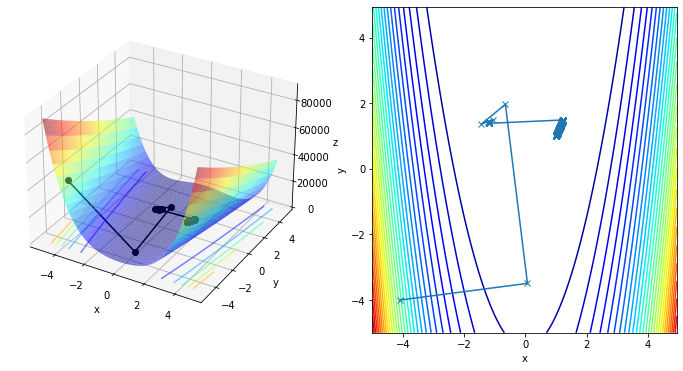

In [108]:
fin, points_GD, iterations = grad_desc(Ros_func, init)
with np.printoptions(precision=5, suppress=True):
    print(f'Минимум: [x, y] = {fin}')
print(f'Число итераций: {iterations}')
plotter(Ros_func, points_GD)

In [109]:
Ros_func = lambda x, y: 100*(y - x**2)**2 + (1 - x)**2
init = np.array([-4.1, -4.])

Минимум: [x, y] = [1.      1.00001]
Число итераций: 128


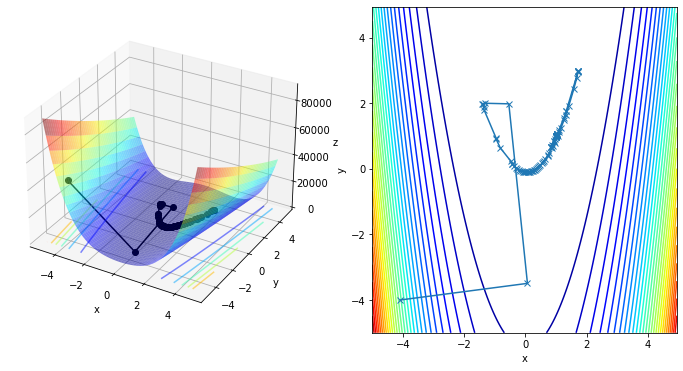

In [110]:
fin, points_GDFR, iterations = CG_grad_desc(Ros_func, init, 'Fletcher-Reeves')
with np.printoptions(precision=5, suppress=True):
    print(f'Минимум: [x, y] = {fin}')
print(f'Число итераций: {iterations}')
plotter(Ros_func, points_GDFR)

In [111]:
Ros_func = lambda x, y: 100*(y - x**2)**2 + (1 - x)**2
init = np.array([-4.1, -4.])

Минимум: [x, y] = [1. 1.]
Число итераций: 91


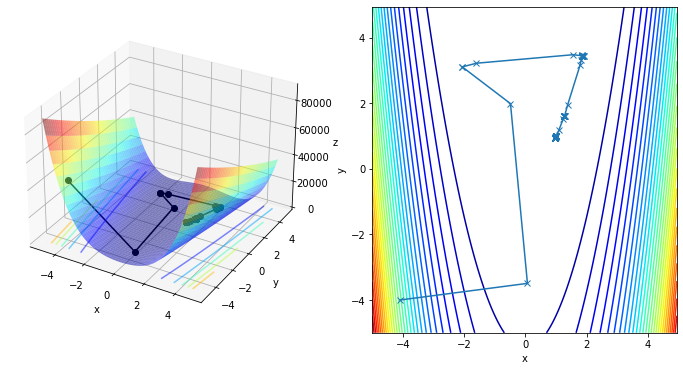

In [112]:
fin, points_GDPR, iterations = CG_grad_desc(Ros_func, init, 'Polak-Ribiere')
with np.printoptions(precision=5, suppress=True):
    print(f'Минимум: [x, y] = {fin}')
print(f'Число итераций: {iterations}')
plotter(Ros_func, points_GDPR)

In [113]:
Ros_func = lambda x, y: 100*(y - x**2)**2 + (1 - x)**2
init = np.array([-4.1, -4.])

Минимум: [x, y] = [0.99997 0.99994]
Число итераций: 69


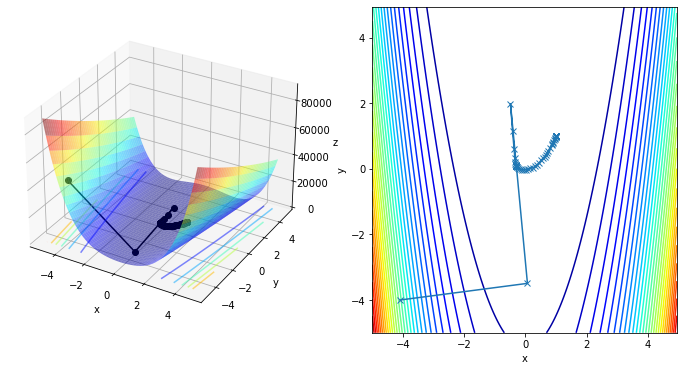

In [114]:
fin, points_BFGS, iterations = BFGS(Ros_func, init)
with np.printoptions(precision=5, suppress=True):
    print(f'Минимум: [x, y] = {fin}')
print(f'Число итераций: {iterations}')
plotter(Ros_func, points_BFGS)